In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  
import seaborn as sns

import optuna
from xgboost import XGBClassifier

In [19]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

Loading the dataset, pre-processing, and analysing the data

In [20]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

icustay_id  anion_gap_mean  anion_gap_sd  anion_gap_min  anion_gap_max  \
0          200003       13.375000      3.583195            9.0           21.0   
1          200007       15.500000      2.121320           14.0           17.0   
2          200009        9.500000      2.121320            8.0           11.0   
3          200012             NaN           NaN            NaN            NaN   
4          200014       10.000000      1.732051            9.0           12.0   
...           ...             ...           ...            ...            ...   
30484      299992       15.375000      2.856153           11.0           25.0   
30485      299993        9.400000      1.341641            8.0           11.0   
30486      299994       16.157895      2.477973           13.0           24.0   
30487      299998       11.500000      1.732051           10.0           14.0   
30488      299999             NaN           NaN            NaN            NaN   

       bicarbonate_mean  bicarbonate_sd  bicarbonate_min  bicarbonate_max  \
0             25.250000        3.105295             18.0             28.0   
1             23.000000        1.414214             22.0             24.0   
2             23.333333        2.081666             21.0             25.0   
3                   NaN             NaN              NaN              NaN   
4             24.000000        1.000000             23.0             25.0   
...                 ...             ...              ...              ...   
30484         23.125000        2.609556             15.0             26.0   
30485         29.600000        2.073644             26.0             31.0   
30486         21.631579        3.451417             17.0             31.0   
30487         23.500000        1.290994             22.0             25.0   
30488         24.000000             NaN             24.0             24.0   

       calcium_total_mean  ...  urea_nitrogen_min  urea_nitrogen_max  \
0                7.771429  ...               10.0               21.0   
1                8.900000  ...                8.0               10.0   
2                8.000000  ...               15.0               21.0   
3                     NaN  ...                NaN                NaN   
4                7.733333  ...               21.0               24.0   
...                   ...  ...                ...                ...   
30484            8.307143  ...                8.0               23.0   
30485            8.000000  ...               12.0               15.0   
30486            8.100000  ...               28.0               63.0   
30487            8.800000  ...               20.0               22.0   
30488                 NaN  ...               11.0               13.0   

       white_blood_cells_mean  white_blood_cells_sd  white_blood_cells_min  \
0                   26.471429             13.176711                   13.2   
1                   10.300000              1.272792                    9.4   
2                   12.471429              1.471637                   10.5   
3                    4.900000                   NaN                    4.9   
4                   13.233333              2.203028                   10.7   
...                       ...                   ...                    ...   
30484               14.134783              3.781727                    8.1   
30485               12.600000              0.605530                   12.0   
30486               10.076190              2.642329                    5.3   
30487                9.900000              1.210372                    7.9   
30488               18.300000              3.394113                   15.9   

       white_blood_cells_max  age  gender  icu_los_hours  target  
0                       43.9   48       M            141       0  
1                       11.2   44       M             30       0  
2                       14.3   47       F             51       0  
3                        4.9   33      

In [21]:
lab_cols = [
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age', 'icu_los_hours'
]

In [22]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']
imputer = SimpleImputer(strategy="median")
df[lab_cols] = imputer.fit_transform(df[lab_cols])

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 90)


In [23]:
# Test-Train split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7, shuffle=True)

imputer = SimpleImputer(strategy="median")
X_train_full = imputer.fit_transform(X_train_full) # fit on training only
X_test  = imputer.transform(X_test) # transform test using train params

print(np.shape(X_train_full))
print(np.shape(X_test))
print(np.shape(y_train_full))
print(np.shape(y_test))

print(f'# Readmissions in Train: {np.sum(y_train_full)}')
print(f'# Readmissions in Test: {np.sum(y_test) }')
print(f'% Readmissions in Train: {np.mean(y_train_full) * 100}')
print(f'% Readmissions in Test: {np.mean(y_test) * 100}')
print(f'Total: {np.sum(y), np.mean(y)*100}')

(21342, 90)
(9147, 90)
(21342,)
(9147,)
# Readmissions in Train: 2293
# Readmissions in Test: 983
% Readmissions in Train: 10.744072720457314
% Readmissions in Test: 10.746692904777523
Total: (np.int64(3276), np.float64(10.74485880153498))


In [24]:
def objective(trial):
    # Train-Dev split for 
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, stratify=y_train_full, random_state=7)

    # Handle imbalance
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 7,
        "eval_metric": "auc",
        "tree_method": "hist",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc

Hyperparameters

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Search for hyperparameters complete:")
print(study.best_params)

[I 2025-12-01 21:10:55,350] A new study created in memory with name: no-name-f920822b-5946-49a9-886a-e7d71d9c76ac


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:10:55] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:10:59,515] Trial 0 finished with value: 0.6983364361431565 and parameters: {'learning_rate': 0.007023238564455873, 'max_depth': 3, 'min_child_weight': 11, 'gamma': 0.06811323520208201, 'subsample': 0.8453746584983299, 'colsample_bytree': 0.8293073877459685, 'reg_alpha': 0.1979446026742946, 'reg_lambda': 1.2688485813217114, 'n_estimators': 1428, 'max_delta_step': 6}. Best is trial 0 with value: 0.6983364361431565.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:10:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:11:40,631] Trial 1 finished with value: 0.7009486459541394 and parameters: {'learning_rate': 0.006424534077606939, 'max_depth': 16, 'min_child_weight': 4, 'gamma': 0.026292249334688877, 'subsample': 0.6125236130341182, 'colsample_bytree': 0.5468846161863898, 'reg_alpha': 0.8447847308601455, 'reg_lambda': 1.9032334959094823, 'n_estimators': 2721, 'max_delta_step': 10}. Best is trial 1 with value: 0.7009486459541394.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:11:40] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:12:15,226] Trial 2 finished with value: 0.7000915583226516 and parameters: {'learning_rate': 0.004219956600723274, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.4446439944770916, 'subsample': 0.7051211030120839, 'colsample_bytree': 0.525434126858896, 'reg_alpha': 0.9703172511721992, 'reg_lambda': 1.5328996682528344, 'n_estimators': 2326, 'max_delta_step': 10}. Best is trial 1 with value: 0.7009486459541394.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:12:15] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:12:25,535] Trial 3 finished with value: 0.6768115831451301 and parameters: {'learning_rate': 0.026032728393543612, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.34478989738631094, 'subsample': 0.5255631720214824, 'colsample_bytree': 0.7339715604406175, 'reg_alpha': 0.9435738575445125, 'reg_lambda': 1.2665139245836436, 'n_estimators': 2872, 'max_delta_step': 3}. Best is trial 1 with value: 0.7009486459541394.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:12:25] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:12:29,734] Trial 4 finished with value: 0.6959777920201835 and parameters: {'learning_rate': 0.0053203362521153826, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 0.9279082684073685, 'subsample': 0.8529563115113374, 'colsample_bytree': 0.9553223583824575, 'reg_alpha': 0.6688052951319473, 'reg_lambda': 1.334748558334412, 'n_estimators': 570, 'max_delta_step': 3}. Best is trial 1 with value: 0.7009486459541394.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:12:29] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:13:01,326] Trial 5 finished with value: 0.6916727705548433 and parameters: {'learning_rate': 0.013310771041647677, 'max_depth': 17, 'min_child_weight': 13, 'gamma': 0.5425696268103215, 'subsample': 0.6096290562257093, 'colsample_bytree': 0.8501547564171986, 'reg_alpha': 0.22419150236420543, 'reg_lambda': 1.5623843538173339, 'n_estimators': 3085, 'max_delta_step': 8}. Best is trial 1 with value: 0.7009486459541394.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:13:01] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:13:29,563] Trial 6 finished with value: 0.7016837829864291 and parameters: {'learning_rate': 0.014529234199796591, 'max_depth': 17, 'min_child_weight': 4, 'gamma': 0.9789399121695546, 'subsample': 0.8960798552446294, 'colsample_bytree': 0.5716092704020693, 'reg_alpha': 0.9676449515208634, 'reg_lambda': 1.2844670322777225, 'n_estimators': 4997, 'max_delta_step': 1}. Best is trial 6 with value: 0.7016837829864291.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:13:29] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:14:08,370] Trial 7 finished with value: 0.7069950558505768 and parameters: {'learning_rate': 0.002148704553823734, 'max_depth': 23, 'min_child_weight': 10, 'gamma': 0.40480301986795464, 'subsample': 0.5690510560771004, 'colsample_bytree': 0.7520812422844717, 'reg_alpha': 0.6881603852444537, 'reg_lambda': 1.3691750061803976, 'n_estimators': 2023, 'max_delta_step': 1}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:14:08] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:14:21,374] Trial 8 finished with value: 0.6709485442226698 and parameters: {'learning_rate': 0.08287170303495965, 'max_depth': 11, 'min_child_weight': 14, 'gamma': 0.9449620276607182, 'subsample': 0.4488763178103804, 'colsample_bytree': 0.6287215519641876, 'reg_alpha': 0.04587256233821778, 'reg_lambda': 0.3105157046305378, 'n_estimators': 2847, 'max_delta_step': 9}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:14:21] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:14:57,885] Trial 9 finished with value: 0.7025562575026959 and parameters: {'learning_rate': 0.0048671507433064535, 'max_depth': 23, 'min_child_weight': 9, 'gamma': 0.6198610989821096, 'subsample': 0.8770272428961785, 'colsample_bytree': 0.4057706139878403, 'reg_alpha': 0.7596152560915663, 'reg_lambda': 1.2087154189171305, 'n_estimators': 1886, 'max_delta_step': 8}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:14:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:17:12,282] Trial 10 finished with value: 0.7003608923884515 and parameters: {'learning_rate': 0.0010163837974455077, 'max_depth': 25, 'min_child_weight': 6, 'gamma': 0.2772011496035714, 'subsample': 0.9992349592996796, 'colsample_bytree': 0.768007820562482, 'reg_alpha': 0.5085237309393631, 'reg_lambda': 0.6946510932317222, 'n_estimators': 3821, 'max_delta_step': 0}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:12] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:17:50,077] Trial 11 finished with value: 0.7040047864656453 and parameters: {'learning_rate': 0.0012643932375447987, 'max_depth': 25, 'min_child_weight': 9, 'gamma': 0.6930726069015952, 'subsample': 0.7332505251542594, 'colsample_bytree': 0.40515167398203866, 'reg_alpha': 0.6455564735744682, 'reg_lambda': 0.8168971524569029, 'n_estimators': 1515, 'max_delta_step': 6}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:50] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:18:19,078] Trial 12 finished with value: 0.7025593094467842 and parameters: {'learning_rate': 0.0010329400620808667, 'max_depth': 21, 'min_child_weight': 7, 'gamma': 0.7357019382241546, 'subsample': 0.714304934488716, 'colsample_bytree': 0.409110678662706, 'reg_alpha': 0.5543244131780656, 'reg_lambda': 0.7690945357457701, 'n_estimators': 1034, 'max_delta_step': 5}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:18:19] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:19:19,123] Trial 13 finished with value: 0.6917086308978819 and parameters: {'learning_rate': 0.0023051058220249065, 'max_depth': 21, 'min_child_weight': 1, 'gamma': 0.7422978740130256, 'subsample': 0.6099793263903212, 'colsample_bytree': 0.6784726044443958, 'reg_alpha': 0.3534008065684558, 'reg_lambda': 0.14882376273663334, 'n_estimators': 1587, 'max_delta_step': 5}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:19] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:19:30,190] Trial 14 finished with value: 0.7023878919204867 and parameters: {'learning_rate': 0.0021328279275263855, 'max_depth': 25, 'min_child_weight': 10, 'gamma': 0.2436891692040054, 'subsample': 0.41365017239752444, 'colsample_bytree': 0.889867101743929, 'reg_alpha': 0.6354952316515132, 'reg_lambda': 0.8037843108111001, 'n_estimators': 566, 'max_delta_step': 3}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:30] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:19:37,480] Trial 15 finished with value: 0.6577694866630044 and parameters: {'learning_rate': 0.2378426375425094, 'max_depth': 21, 'min_child_weight': 11, 'gamma': 0.7212711601734801, 'subsample': 0.7672260494485881, 'colsample_bytree': 0.6563862320097257, 'reg_alpha': 0.39733651919393564, 'reg_lambda': 0.3960815584986057, 'n_estimators': 2102, 'max_delta_step': 6}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:20:27,127] Trial 16 finished with value: 0.7061420374778734 and parameters: {'learning_rate': 0.0020636459826547057, 'max_depth': 19, 'min_child_weight': 15, 'gamma': 0.44753060585705556, 'subsample': 0.5303170453186625, 'colsample_bytree': 0.4884385833913386, 'reg_alpha': 0.7487863934396182, 'reg_lambda': 0.9761994653447055, 'n_estimators': 3612, 'max_delta_step': 1}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:27] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:20:55,138] Trial 17 finished with value: 0.6794649942013062 and parameters: {'learning_rate': 0.03353912358689195, 'max_depth': 19, 'min_child_weight': 15, 'gamma': 0.4853746425790296, 'subsample': 0.5053309764338092, 'colsample_bytree': 0.7569544338342152, 'reg_alpha': 0.8211284502539338, 'reg_lambda': 1.768558091084701, 'n_estimators': 3836, 'max_delta_step': 1}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:55] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:21:36,975] Trial 18 finished with value: 0.7017034934586666 and parameters: {'learning_rate': 0.0024464394962441117, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.1652886966303926, 'subsample': 0.5459565547549928, 'colsample_bytree': 0.480120140085053, 'reg_alpha': 0.7477690843407568, 'reg_lambda': 0.9904498152672719, 'n_estimators': 3592, 'max_delta_step': 0}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:22:01,294] Trial 19 finished with value: 0.6773980650674479 and parameters: {'learning_rate': 0.0580110789879565, 'max_depth': 19, 'min_child_weight': 15, 'gamma': 0.3140635519936572, 'subsample': 0.6396502838435836, 'colsample_bytree': 0.9882857120149957, 'reg_alpha': 0.45846595531503354, 'reg_lambda': 1.0298177869732508, 'n_estimators': 4473, 'max_delta_step': 2}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:22:01] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:22:32,412] Trial 20 finished with value: 0.6923744633664978 and parameters: {'learning_rate': 0.010139624779778682, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.3805785255033044, 'subsample': 0.4760594888203727, 'colsample_bytree': 0.6210943224011879, 'reg_alpha': 0.8701902066480547, 'reg_lambda': 1.030958146419447, 'n_estimators': 3316, 'max_delta_step': 2}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:22:32] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:23:04,552] Trial 21 finished with value: 0.7031309131416713 and parameters: {'learning_rate': 0.0016920083984195047, 'max_depth': 23, 'min_child_weight': 9, 'gamma': 0.6050811014786052, 'subsample': 0.7724468386540503, 'colsample_bytree': 0.4753608249931395, 'reg_alpha': 0.6363279933420959, 'reg_lambda': 0.5671467775518508, 'n_estimators': 1201, 'max_delta_step': 4}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:04] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:23:48,335] Trial 22 finished with value: 0.7061639097438401 and parameters: {'learning_rate': 0.003247570440447061, 'max_depth': 23, 'min_child_weight': 7, 'gamma': 0.8267331332986141, 'subsample': 0.5560745838184017, 'colsample_bytree': 0.4663715694835582, 'reg_alpha': 0.7240058116595446, 'reg_lambda': 0.9314370843955151, 'n_estimators': 2395, 'max_delta_step': 7}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:48] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:24:34,239] Trial 23 finished with value: 0.7058569350342835 and parameters: {'learning_rate': 0.0030665474220605104, 'max_depth': 23, 'min_child_weight': 6, 'gamma': 0.8578882588133807, 'subsample': 0.5622475194709013, 'colsample_bytree': 0.4738581908061394, 'reg_alpha': 0.7491430001631583, 'reg_lambda': 1.6349359153802974, 'n_estimators': 2379, 'max_delta_step': 7}. Best is trial 7 with value: 0.7069950558505768.


C:\Users\risha\AppData\Local\Temp\ipykernel_25020\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:24:34] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-12-01 21:25:15,741] Trial 24 finished with value: 0.7030913650328593 and parameters: {'learning_rate': 0.0034442061515163637, 'max_depth': 19, 'min_child_weight': 7, 'gamma': 0.41887998521523917, 'subsample': 0.6592980929327842, 'colsample_bytree': 0.5860348242409734, 'reg_alpha': 0.5631846433460688, 'reg_lambda': 0.9611828952175814, 'n_estimators': 1914, 'max_delta_step': 1}. Best is trial 7 with value: 0.7069950558505768.
Search for hyperparameters complete:
{'learning_rate': 0.002148704553823734, 'max_depth': 23, 'min_child_weight': 10, 'gamma': 0.40480301986795464, 'subsample': 0.5690510560771004, 'colsample_bytree': 0.7520812422844717, 'reg_alpha': 0.6881603852444537, 'reg_lambda': 1.3691750061803976, 'n_estimators': 2023, 'max_delta_step': 1}


In [26]:
# using the best hyperparams for final training on complete training set
best_params = study.best_params
best_params.update({
    "random_state": 7,
    "eval_metric": "auc",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:15] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7520812422844717, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.40480301986795464, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.002148704553823734,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=1, max_depth=23, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2023, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      8164
           1       0.37      0.22      0.28       983

    accuracy                           0.88      9147
   macro avg       0.64      0.59      0.61      9147
weighted avg       0.85      0.88      0.86      9147

ROC-AUC: 0.7458
95% CI = [0.7301, 0.7615]


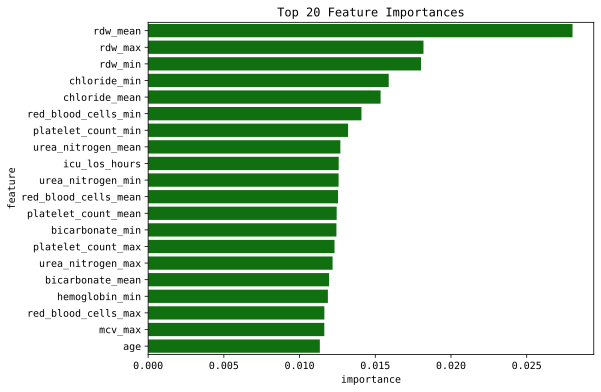

In [27]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)

np.savez(f'../results/xgboost_imputed_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()